In [71]:
from sqlalchemy import create_engine
import numpy as np
import pymysql
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
from math import sqrt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
#data
rawData = pd.read_csv('credit_export.csv')
rawData.head()

LIMIT_BAL     SEX        EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0     300000    male       university         1   37      1     -1      2   
1     250000  female  graduate school         1   32      1     -1      0   
2     430000  female       university         1   32     -2     -2     -1   
3     200000    male  graduate school         1   36      1     -2     -1   
4      50000    male       university         1   32      1     -2     -1   

   PAY_4  PAY_5  ...  BILL_JUN  BILL_MAY  BILL_APR  PAY_SEP  PAY_AUG  PAY_JUL  \
0      0      0  ...     30355     26771     23737   505000      331     1070   
1      0      0  ...    180488    173140    170233   225066   198031     6069   
2      2      0  ...     77875     62675     48764        8   145740        7   
3     -1     -2  ...     -3684         0      1386    10118    47015        0   
4     -1     -1  ...      2850      6340      3110    10000    10000     7867   

   PAY_JUN  PAY_MAY  PAY_APR  default payment next month  
0    17771    18000    16079                 not default  
1     4310     5752     4638                 not default  
2     2500     2021     2000                 not default  
3     4000   100000    10000                 not default  
4     6340     3000     2218                 not default  

[5 rows x 24 columns]

In [3]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   30000 non-null  int64 
 1   SEX                         30000 non-null  object
 2   EDUCATION                   30000 non-null  object
 3   MARRIAGE                    30000 non-null  int64 
 4   AGE                         30000 non-null  int64 
 5   PAY_0                       30000 non-null  int64 
 6   PAY_2                       30000 non-null  int64 
 7   PAY_3                       30000 non-null  int64 
 8   PAY_4                       30000 non-null  int64 
 9   PAY_5                       30000 non-null  int64 
 10  PAY_6                       30000 non-null  int64 
 11  BILL_SEP                    30000 non-null  int64 
 12  BILL_AUG                    30000 non-null  int64 
 13  BILL_JUL                    30000 non-null  in

In [4]:
rawData = rawData.drop_duplicates()
rawData['default'] = rawData['default payment next month']
rawData = rawData.drop('default payment next month', 1)

In [88]:
rawData = rawData.rename(columns={'PAY_0': 'PAY_SEP', 'PAY_2': 'PAY_AUG', 'PAY_3': 'PAY_JUL', 'PAY_4': 'PAY_JUN',
                                'PAY_5': 'PAY_MAY', 'PAY_6': 'PAY_APR', 'BILL_AMT1': 'BILL_SEP',
                                'BILL_AMT2': 'BILL_AUG', 'BILL_AMT3': 'BILL_JUL', 'BILL_AMT4': 'BILL_JUN',
                                'BILL_AMT5': 'BILL_MAY', 'BILL_AMT6': 'BILL_APR', 'PAY_AMT1': 'PAID_SEP',
                                'PAY_AMT2': 'PAID_AUG', 'PAY_AMT3': 'PAID_JUL', 'PAY_AMT4': 'PAID_JUN',
                                'PAY_AMT5': 'PAID_MAY','PAY_AMT6': 'PAID_APR','default payment next month': 'DEFAULT'})
rawData.head()

LIMIT_BAL  AGE  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  PAY_APR  \
0     300000   37        1        0        2        0        0        0   
1     250000   32        1        0        0        0        0        0   
2     430000   32        0        0        0        2        0        0   
3     200000   36        1        0        0        0        0        0   
4      50000   32        1        0        0        0        0        0   

   BILL_SEP  BILL_AUG  ...  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  \
0   -165580    324392  ...   505000      331     1070    17771    18000   
1   -154973     59514  ...   225066   198031     6069     4310     5752   
2    -15308    -33350  ...        8   145740        7     2500     2021   
3    -14386    -13543  ...    10118    47015        0     4000   100000   
4    -11545     -1935  ...    10000    10000     7867     6340     3000   

   PAY_APR  EDUCATION_graduate school  default_default  default_not default  \
0    16079                          0                0                    1   
1     4638                          1                0                    1   
2     2000                          0                0                    1   
3    10000                          1                0                    1   
4     2218                          0                0                    1   

   Limit_bins  
0     100-300  
1     100-300  
2    300-1000  
3     100-300  
4        0-50  

[5 rows x 24 columns]

In [89]:
#shift pay features for -2 and -1 values to 0
rawData['PAY_SEP'] = rawData['PAY_SEP'].replace(-2,0)
rawData['PAY_AUG'] = rawData['PAY_AUG'].replace(-2,0)
rawData['PAY_JUL'] = rawData['PAY_JUL'].replace(-2,0)
rawData['PAY_JUN'] = rawData['PAY_JUN'].replace(-2,0)
rawData['PAY_MAY'] = rawData['PAY_MAY'].replace(-2,0)
rawData['PAY_APR'] = rawData['PAY_APR'].replace(-2,0)

rawData['PAY_SEP'] = rawData['PAY_SEP'].replace(-1,0)
rawData['PAY_AUG'] = rawData['PAY_AUG'].replace(-1,0)
rawData['PAY_JUL'] = rawData['PAY_JUL'].replace(-1,0)
rawData['PAY_JUN'] = rawData['PAY_JUN'].replace(-1,0)
rawData['PAY_MAY'] = rawData['PAY_MAY'].replace(-1,0)
rawData['PAY_APR'] = rawData['PAY_APR'].replace(-1,0)

In [90]:
pd.value_counts(rawData.values.flatten())

0          258794
1           44333
2           19064
100-300     12920
2000         7838
            ...  
44881           1
44880           1
44879           1
44876           1
214669          1
Length: 83036, dtype: int64

In [91]:
rawData = pd.get_dummies(rawData)

In [92]:
rawData.dtypes

LIMIT_BAL                    int64
AGE                          int64
PAY_SEP                      int64
PAY_AUG                      int64
PAY_JUL                      int64
PAY_JUN                      int64
PAY_MAY                      int64
PAY_APR                      int64
BILL_SEP                     int64
BILL_AUG                     int64
BILL_JUL                     int64
BILL_JUN                     int64
BILL_MAY                     int64
BILL_APR                     int64
PAY_SEP                      int64
PAY_AUG                      int64
PAY_JUL                      int64
PAY_JUN                      int64
PAY_MAY                      int64
PAY_APR                      int64
EDUCATION_graduate school    uint8
default_default              uint8
default_not default          uint8
Limit_bins_0-50              uint8
Limit_bins_50-100            uint8
Limit_bins_100-300           uint8
Limit_bins_300-1000          uint8
dtype: object

<b>Filtering</b>
Removing features that have lowest correlation with LIMIT_BAL

In [93]:
rawData = rawData.drop(['MARRIAGE','SEX_female', 'SEX_male','EDUCATION_high school', 'EDUCATION_university', 'EDUCATION_other'], axis=1)

KeyError: "['MARRIAGE' 'SEX_female' 'SEX_male' 'EDUCATION_high school'\n 'EDUCATION_university' 'EDUCATION_other'] not found in axis"

In [11]:
rawData.head()

LIMIT_BAL  AGE  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  PAY_APR  \
0     300000   37        1        0        2        0        0        0   
1     250000   32        1        0        0        0        0        0   
2     430000   32        0        0        0        2        0        0   
3     200000   36        1        0        0        0        0        0   
4      50000   32        1        0        0        0        0        0   

   BILL_SEP  BILL_AUG  ...  BILL_APR  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  \
0   -165580    324392  ...     23737   505000      331     1070    17771   
1   -154973     59514  ...    170233   225066   198031     6069     4310   
2    -15308    -33350  ...     48764        8   145740        7     2500   
3    -14386    -13543  ...      1386    10118    47015        0     4000   
4    -11545     -1935  ...      3110    10000    10000     7867     6340   

   PAY_MAY  PAY_APR  EDUCATION_graduate school  default_default  \
0    18000    16079                          0                0   
1     5752     4638                          1                0   
2     2021     2000                          0                0   
3   100000    10000                          1                0   
4     3000     2218                          0                0   

   default_not default  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  

[5 rows x 23 columns]

<b>Modeling</b>

In [12]:
X = rawData.iloc[:,1:]
y = rawData['LIMIT_BAL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [13]:
algos_class = []
algos_class.append(('Random Forest', RandomForestRegressor()))
algos_class.append(('Linear Model', LinearRegression()))
algos_class.append(('SVC', SVR()))

In [14]:
results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model,X,y, cv=3)
    names.append(name)
    results.append(result)

In [15]:
for i in range(len(names)):
    print(names[i], results[i].mean() )

Random Forest 0.3285747843870381
Linear Model -2.0548895685084134
SVC -0.2914161928285464


### Random Forest 0.33 clearly shows that is it not possible to have a reliable model for predicting Credit Limit

In [16]:
algo = RandomForestRegressor()
modelRF = algo.fit(X_train,y_train)

In [17]:
#Make Predictions
predictions = modelRF.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.469
RMSE: 95603.245


Need to discretize Limit Bal - let's analyze

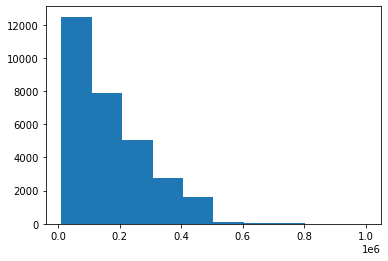

In [18]:
plt.hist(rawData['LIMIT_BAL'], bins=10)
plt.show()

In [60]:
df = rawData
df['Limit_bins']= pd.cut(df.LIMIT_BAL, bins=[0,50000,100000,300000,1000000],labels=['0-50','50-100','100-300','300-1000'])

In [61]:
df.head()

LIMIT_BAL  AGE  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  PAY_APR  \
0     300000   37        1        0        2        0        0        0   
1     250000   32        1        0        0        0        0        0   
2     430000   32        0        0        0        2        0        0   
3     200000   36        1        0        0        0        0        0   
4      50000   32        1        0        0        0        0        0   

   BILL_SEP  BILL_AUG  ...  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  \
0   -165580    324392  ...   505000      331     1070    17771    18000   
1   -154973     59514  ...   225066   198031     6069     4310     5752   
2    -15308    -33350  ...        8   145740        7     2500     2021   
3    -14386    -13543  ...    10118    47015        0     4000   100000   
4    -11545     -1935  ...    10000    10000     7867     6340     3000   

   PAY_APR  EDUCATION_graduate school  default_default  default_not default  \
0    16079                          0                0                    1   
1     4638                          1                0                    1   
2     2000                          0                0                    1   
3    10000                          1                0                    1   
4     2218                          0                0                    1   

   Limit_bins  
0     100-300  
1     100-300  
2    300-1000  
3     100-300  
4        0-50  

[5 rows x 24 columns]

In [62]:
df.groupby(['Limit_bins', 'default_not default'])['default_not default'].count()

Limit_bins  default_not default
0-50        0                       2439
            1                       5234
50-100      0                       1244
            1                       3573
100-300     0                       2345
            1                      10575
300-1000    0                        602
            1                       3953
Name: default_not default, dtype: int64

In [63]:
pivot = pd.pivot_table(df,index=df['Limit_bins'],columns='default_not default', values='Limit_bins', aggfunc='count', fill_value=0)
pivot.plot.bar(figsize=(16,9))

In [64]:
df['Limit_bins'].value_counts()

100-300     12920
0-50         7673
50-100       4817
300-1000     4555
Name: Limit_bins, dtype: int64

In [65]:
#features 
X1 = df.iloc[:,1:23]
print('Summary of feature sample')
X1.head()

Summary of feature sample


AGE  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  PAY_APR  BILL_SEP  \
0   37        1        0        2        0        0        0   -165580   
1   32        1        0        0        0        0        0   -154973   
2   32        0        0        0        2        0        0    -15308   
3   36        1        0        0        0        0        0    -14386   
4   32        1        0        0        0        0        0    -11545   

   BILL_AUG  BILL_JUL  ...  BILL_APR  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  \
0    324392    296931  ...     23737   505000      331     1070    17771   
1     59514    220765  ...    170233   225066   198031     6069     4310   
2    -33350     95740  ...     48764        8   145740        7     2500   
3    -13543      3432  ...      1386    10118    47015        0     4000   
4     -1935      7321  ...      3110    10000    10000     7867     6340   

   PAY_MAY  PAY_APR  EDUCATION_graduate school  default_default  \
0    18000    16079                          0                0   
1     5752     4638                          1                0   
2     2021     2000                          0                0   
3   100000    10000                          1                0   
4     3000     2218                          0                0   

   default_not default  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  

[5 rows x 22 columns]

In [66]:
X1 = df.iloc[:,1:23]
y1 = df['Limit_bins']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.25, random_state=124)

In [67]:
algo1 = DecisionTreeClassifier(max_depth=3)
modelDT = algo1.fit(X_train1,y_train1)

In [68]:
#Predictions
preds = modelDT.predict(X_test1)

In [69]:
print(classification_report(y_test1, preds))

              precision    recall  f1-score   support

        0-50       0.63      0.77      0.69      1919
     100-300       0.61      0.78      0.69      3247
    300-1000       0.86      0.09      0.17      1114
      50-100       0.55      0.39      0.46      1212

    accuracy                           0.61      7492
   macro avg       0.66      0.51      0.50      7492
weighted avg       0.64      0.61      0.57      7492



## Model Accuracy = 0.61

In [73]:
fig = plt.figure(figsize=(25,20))
tree = plot_tree(modelDT, feature_names=X1.columns,class_names=['0-50', '50-100', '100-300', '300-1000'], filled=True)

<b>Predicting whether to approve someone using Default/Not default as dependent variable</b>

In [97]:
#data
appr = pd.read_csv('credit_export.csv')
appr.head()

LIMIT_BAL     SEX        EDUCATION  MARRIAGE  AGE  PAY_SEP  PAY_AUG  \
0     300000    male       university         1   37        1       -1   
1     250000  female  graduate school         1   32        1       -1   
2     430000  female       university         1   32       -2       -2   
3     200000    male  graduate school         1   36        1       -2   
4      50000    male       university         1   32        1       -2   

   PAY_JUL  PAY_JUN  PAY_MAY  ...  BILL_JUN  BILL_MAY  BILL_APR  PAID_SEP  \
0        2        0        0  ...     30355     26771     23737    505000   
1        0        0        0  ...    180488    173140    170233    225066   
2       -1        2        0  ...     77875     62675     48764         8   
3       -1       -1       -2  ...     -3684         0      1386     10118   
4       -1       -1       -1  ...      2850      6340      3110     10000   

   PAID_AUG  PAID_JUL  PAID_JUN  PAID_MAY  PAID_APR  \
0       331      1070     17771     18000     16079   
1    198031      6069      4310      5752      4638   
2    145740         7      2500      2021      2000   
3     47015         0      4000    100000     10000   
4     10000      7867      6340      3000      2218   

   default payment next month  
0                 not default  
1                 not default  
2                 not default  
3                 not default  
4                 not default  

[5 rows x 24 columns]

In [98]:
appr = appr.drop_duplicates()
appr['default'] = appr['default payment next month']
appr = appr.drop('default payment next month', 1)
appr.head()

LIMIT_BAL     SEX        EDUCATION  MARRIAGE  AGE  PAY_SEP  PAY_AUG  \
0     300000    male       university         1   37        1       -1   
1     250000  female  graduate school         1   32        1       -1   
2     430000  female       university         1   32       -2       -2   
3     200000    male  graduate school         1   36        1       -2   
4      50000    male       university         1   32        1       -2   

   PAY_JUL  PAY_JUN  PAY_MAY  ...  BILL_JUN  BILL_MAY  BILL_APR  PAID_SEP  \
0        2        0        0  ...     30355     26771     23737    505000   
1        0        0        0  ...    180488    173140    170233    225066   
2       -1        2        0  ...     77875     62675     48764         8   
3       -1       -1       -2  ...     -3684         0      1386     10118   
4       -1       -1       -1  ...      2850      6340      3110     10000   

   PAID_AUG  PAID_JUL  PAID_JUN  PAID_MAY  PAID_APR      default  
0       331      1070     17771     18000     16079  not default  
1    198031      6069      4310      5752      4638  not default  
2    145740         7      2500      2021      2000  not default  
3     47015         0      4000    100000     10000  not default  
4     10000      7867      6340      3000      2218  not default  

[5 rows x 24 columns]

In [99]:
#shift pay features for -2 and -1 values to 0
appr['PAY_SEP'] = appr['PAY_SEP'].replace(-2,0)
appr['PAY_AUG'] = appr['PAY_AUG'].replace(-2,0)
appr['PAY_JUL'] = appr['PAY_JUL'].replace(-2,0)
appr['PAY_JUN'] = appr['PAY_JUN'].replace(-2,0)
appr['PAY_MAY'] = appr['PAY_MAY'].replace(-2,0)
appr['PAY_APR'] = appr['PAY_APR'].replace(-2,0)

appr['PAY_SEP'] = appr['PAY_SEP'].replace(-1,0)
appr['PAY_AUG'] = appr['PAY_AUG'].replace(-1,0)
appr['PAY_JUL'] = appr['PAY_JUL'].replace(-1,0)
appr['PAY_JUN'] = appr['PAY_JUN'].replace(-1,0)
appr['PAY_MAY'] = appr['PAY_MAY'].replace(-1,0)
appr['PAY_APR'] = appr['PAY_APR'].replace(-1,0)

In [100]:
appr = pd.get_dummies(appr)

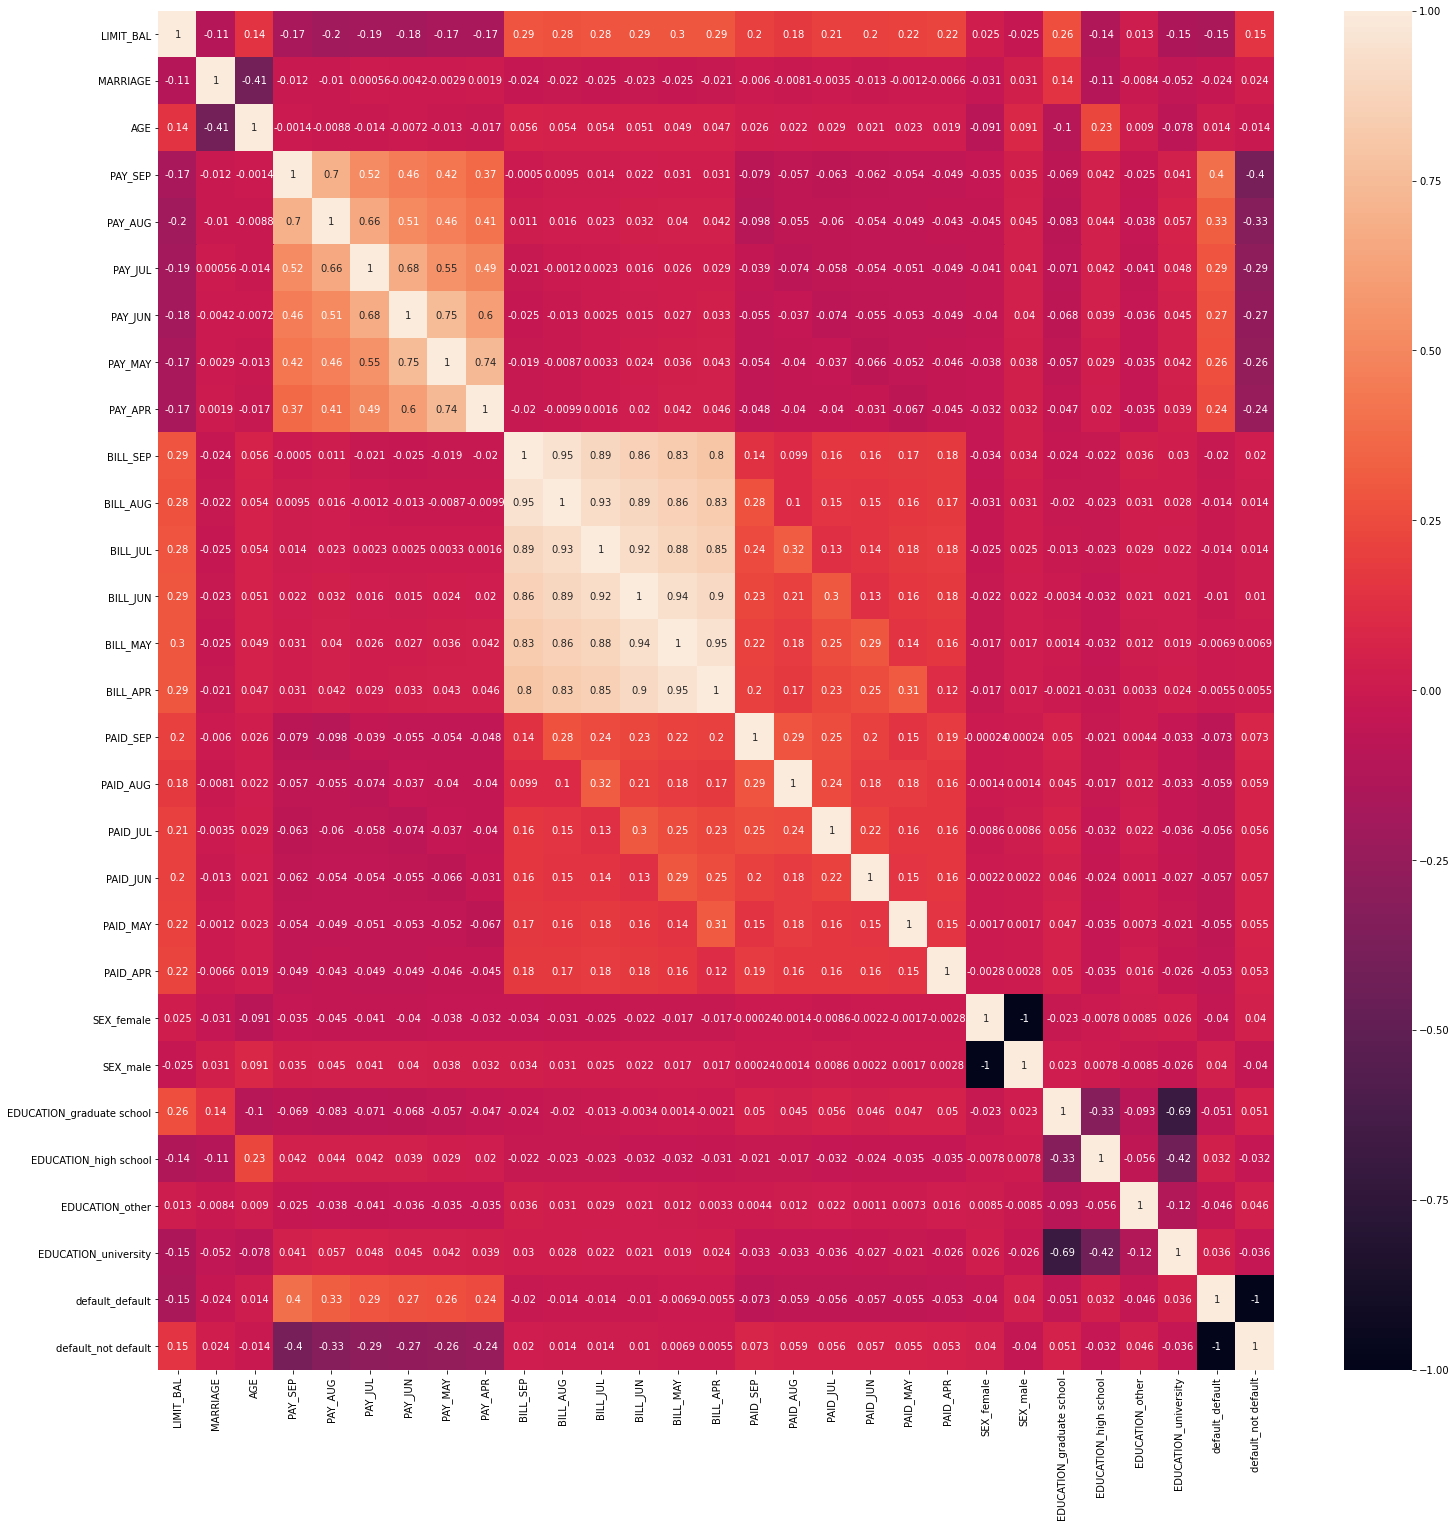

In [101]:
corr = appr.corr()
plt.figure(figsize=(25,25))
sb.heatmap(corr,annot=True)
plt.show()

<b>Filtering</b>
Removing features that have lowest correlation with default_default

In [102]:
appr.head()

LIMIT_BAL  MARRIAGE  AGE  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  \
0     300000         1   37        1        0        2        0        0   
1     250000         1   32        1        0        0        0        0   
2     430000         1   32        0        0        0        2        0   
3     200000         1   36        1        0        0        0        0   
4      50000         1   32        1        0        0        0        0   

   PAY_APR  BILL_SEP  ...  PAID_MAY  PAID_APR  SEX_female  SEX_male  \
0        0   -165580  ...     18000     16079           0         1   
1        0   -154973  ...      5752      4638           1         0   
2        0    -15308  ...      2021      2000           1         0   
3        0    -14386  ...    100000     10000           0         1   
4        0    -11545  ...      3000      2218           0         1   

   EDUCATION_graduate school  EDUCATION_high school  EDUCATION_other  \
0                          0                      0                0   
1                          1                      0                0   
2                          0                      0                0   
3                          1                      0                0   
4                          0                      0                0   

   EDUCATION_university  default_default  default_not default  
0                     1                0                    1  
1                     0                0                    1  
2                     1                0                    1  
3                     0                0                    1  
4                     1                0                    1  

[5 rows x 29 columns]

In [103]:
appr = appr.drop(['MARRIAGE','AGE','BILL_SEP','BILL_AUG','BILL_JUL','BILL_JUN','BILL_MAY','BILL_APR','PAID_SEP','PAID_AUG','PAID_JUL','PAID_JUN','PAID_MAY','PAID_APR','SEX_female', 'SEX_male', 'EDUCATION_graduate school', 'EDUCATION_high school','EDUCATION_university', 'EDUCATION_other','default_not default'], axis=1)
appr.head()

LIMIT_BAL  PAY_SEP  PAY_AUG  PAY_JUL  PAY_JUN  PAY_MAY  PAY_APR  \
0     300000        1        0        2        0        0        0   
1     250000        1        0        0        0        0        0   
2     430000        0        0        0        2        0        0   
3     200000        1        0        0        0        0        0   
4      50000        1        0        0        0        0        0   

   default_default  
0                0  
1                0  
2                0  
3                0  
4                0

In [105]:
appr['default_default'].value_counts()

0    23335
1     6630
Name: default_default, dtype: int64

In [104]:
Xapp = appr.iloc[:,:7]
yapp = appr['default_default']
Xapp_train, Xapp_test, yapp_train, yapp_test = train_test_split(Xapp, yapp, test_size=.25, random_state=123)

In [107]:
algoapp = DecisionTreeClassifier(max_depth=3)
modelapp = algoapp.fit(Xapp_train,yapp_train)

In [109]:
#Predictions
predapp = modelapp.predict(Xapp_test)
print(classification_report(yapp_test, predapp))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5816
           1       0.68      0.37      0.48      1676

    accuracy                           0.82      7492
   macro avg       0.76      0.66      0.68      7492
weighted avg       0.80      0.82      0.80      7492



## Model Accuracy = 0.82

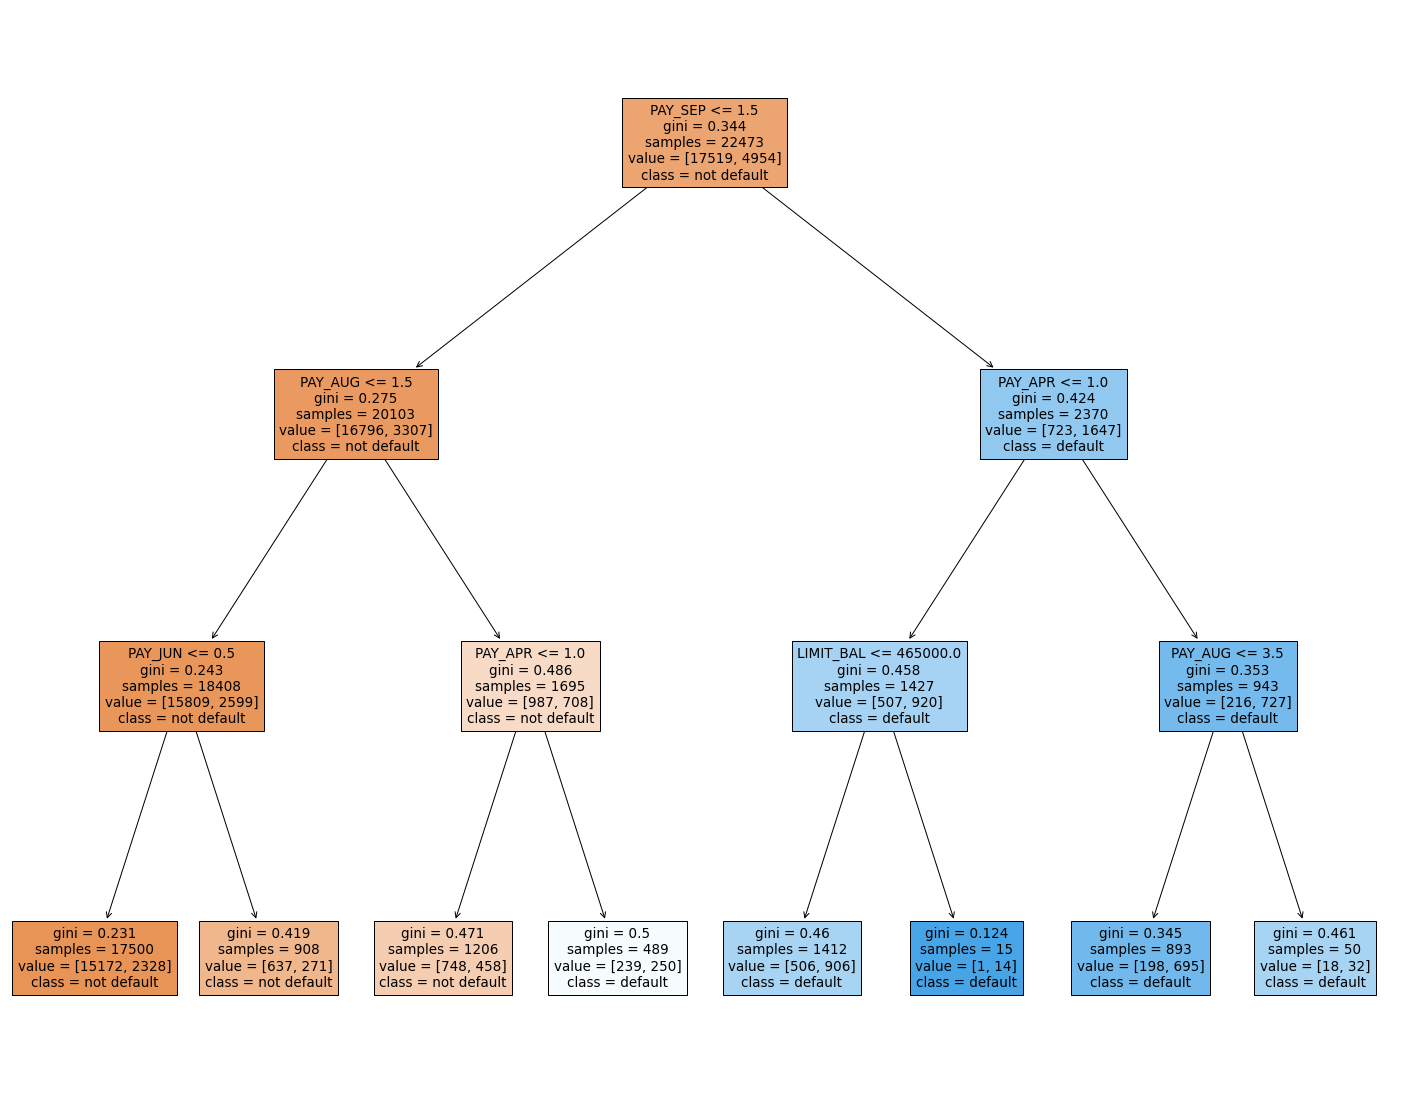

In [111]:
fig = plt.figure(figsize=(25,20))
tree = plot_tree(modelapp, feature_names=Xapp.columns,class_names=['not default', 'default'], filled=True)

<b>We can predict with high accuracy if someone should be approved or not</b>